In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.0 MB/s eta 0:00:00


In [ ]:
import torch

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/KLTN/FDP_VN_1year_binary_FIN_WEIGHTED_SEN_2010_2023.csv")
df.head()

,Code,Year,X1,X2,X3,X4,X5,X6,X7,X8,...,X12,X13,X14,X15,X16,X17,X18,X19,SEN,Next_year_binary_distress_label
0,SD2,2010,1.986111,0.393715,0.413592,0.064695,0.412698,0.144177,0.067961,0.049908,...,0.582255,0.633803,0.230769,6.293419,6.244167,0.151571,0.349353,0.685714,0.0,0
1,SD1,2010,1.093110,0.079239,0.185185,0.026941,0.294118,0.039620,0.062963,0.019017,...,0.855784,6.760000,0.005111,6.447306,5.598422,0.045959,0.134707,0.994444,0.0,0
2,BBC,2010,1.809783,0.196311,0.189086,0.059289,0.385321,0.276680,0.057107,0.054018,...,0.281950,0.785235,0.093093,6.632002,6.669498,0.528327,0.718050,0.859813,0.0,0
3,SD4,2010,0.937282,-0.035928,-0.056250,0.035928,0.596639,0.141717,0.056250,0.025948,...,0.762475,-7.611111,0.356877,6.216606,5.768321,0.441118,0.237525,0.751309,0.0,0
4,SCR,2010,2.259175,0.438298,2.979409,0.077571,0.027879,0.008034,0.527305,0.055578,...,0.711313,0.728365,0.462067,8.934982,7.018402,0.001185,0.288160,0.489354,0.0,0


In [ ]:
sector = pd.read_csv("/content/drive/MyDrive/KLTN/unique_company_with_sector (1).csv")
sector.head()

,Company_Code,ticker,company_name,sector
0,SD2,SD2,Công ty Cổ phần Sông Đà 2,Xây dựng
1,SD1,SD1,Công ty Cổ phần Sông Đà 1,Xây dựng
2,BBC,BBC,Công ty Cổ phần Bibica,Thực phẩm
3,SD4,SD4,Công ty Cổ phần Sông Đà 4,Xây dựng
4,SCR,SCR,Công ty Cổ phần Địa ốc Sài Gòn Thương Tín,Bất động sản


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

In [ ]:
df['Code_clean'] = df['Code'].astype(str).str.strip().str.upper()
sector['ticker_clean'] = sector['ticker'].astype(str).str.strip().str.upper()

# Tạo từ điển map: Ticker -> Sector
sector_map = dict(zip(sector['ticker_clean'], sector['sector']))

# Map vào df chính
df['Sector'] = df['Code_clean'].map(sector_map).fillna('Unknown')

# Set index là Code + Year để dễ theo dõi (giống bài mẫu set_index('Symbol'))
# Lưu ý: Mỗi dòng trong df (một công ty tại một năm) sẽ là 1 Node trong đồ thị
df_indexed = df.reset_index(drop=True)

print("Dữ liệu sau khi gán Sector:")
print(df_indexed[['Code', 'Year', 'Sector']].head())

Dữ liệu sau khi gán Sector:
  Code  Year        Sector
0  SD2  2010      Xây dựng
1  SD1  2010      Xây dựng
2  BBC  2010     Thực phẩm
3  SD4  2010      Xây dựng
4  SCR  2010  Bất động sản


# CREATE GRAPH

GRAPH =

    Temporal edges                         (luôn giữ)
    Similarity edges (ONLY nếu sim > T)    (graph chính)

Sector không tạo edge mới, mà chỉ:

      Nếu (i, j) đã có similarity edge và cùng sector
      → tăng weight lên một chút

### BUILD TEMPORAL EDGES

In [ ]:
edges_temporal = []
weights_temporal = []

for code, g in df.groupby("Code"):
    g = g.sort_values("Year")
    node_ids = g["node_id"].values

    for i in range(len(node_ids) - 1):
        u, v = node_ids[i], node_ids[i+1]
        edges_temporal.append((u, v))
        edges_temporal.append((v, u))
        weights_temporal.append(1.0)
        weights_temporal.append(1.0)

print("Temporal edges:", len(edges_temporal))

Temporal edges: 22498


### COMPUTE COSINE SIMILARITY (GRAPH CHÍNH)

In [ ]:
X = df[feature_cols].values
X = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-8)

sim = cosine_similarity(X)
np.fill_diagonal(sim, 0.0)

### BUILD SIMILARITY EDGES (SPARSE)

In [ ]:
K = 5
SIM_THRESHOLD = 0.95

edges_sim = []
weights_sim = []

for i in range(len(sim)):
    top_k = np.argsort(sim[i])[-K:]   # đã bỏ self
    for j in top_k:
        if sim[i, j] >= SIM_THRESHOLD:
            edges_sim.append((i, j))
            edges_sim.append((j, i))
            weights_sim.append(sim[i, j])
            weights_sim.append(sim[i, j])

print("Similarity edges:", len(edges_sim))

Similarity edges: 126336


### SECTOR BONUS

In [ ]:
sector_bonus = 0.05
sectors = df["Sector"].values

# map edge -> index để cộng bonus
edge_weight_map = {}

for (u, v), w in zip(edges_sim, weights_sim):
    edge_weight_map[(u, v)] = w

for (u, v) in list(edge_weight_map.keys()):
    if sectors[u] == sectors[v]:
        edge_weight_map[(u, v)] += sector_bonus

### MERGE TEMPORAL + SIMILARITY

In [ ]:
edges = []
edge_weights = []

# temporal edges
for (u, v), w in zip(edges_temporal, weights_temporal):
    edges.append((u, v))
    edge_weights.append(w)

# similarity edges (+ sector bonus)
for (u, v), w in edge_weight_map.items():
    edges.append((u, v))
    edge_weights.append(w)

### BUILD PYTORCH GEOMETRIC EDGE_INDEX

In [ ]:
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weights, dtype=torch.float)

In [ ]:
edge_weight = edge_weight / edge_weight.max()

### SANITY CHECK

In [ ]:
num_nodes = len(df)
num_edges = edge_index.shape[1]
avg_degree = num_edges / num_nodes
mean_weight = edge_weight.mean().item()

print(f"Num nodes: {num_nodes}")
print(f"Num edges: {num_edges}")
print(f"Avg degree: {avg_degree:.2f}")
print(f"Mean edge weight: {mean_weight:.4f}")

Num nodes: 12678
Num edges: 111118
Avg degree: 8.76
Mean edge weight: 0.9612


## Đóng gói graph

1 node được nối với node khác nếu

(A) chúng là cùng một công ty ở hai năm liên tiếp (temporal continuity)

(B) hoặc chúng có đặc trưng tài chính đủ giống nhau (feature similarity)

In [ ]:
SAVE_DIR = "/content/drive/MyDrive/KLTN/graph/"

import os
os.makedirs(SAVE_DIR, exist_ok=True)

torch.save(edge_index, SAVE_DIR + "edge_index.pt")
torch.save(edge_weight, SAVE_DIR + "edge_weight.pt")

graph_meta = {
    "num_nodes": num_nodes,
    "num_edges": num_edges,
    "avg_degree": avg_degree,
    "mean_edge_weight": mean_weight,
    "sim_threshold": SIM_THRESHOLD,
    "sector_bonus": sector_bonus,
    "K": K
}

torch.save(graph_meta, SAVE_DIR + "graph_meta.pt")

np.save(SAVE_DIR + "edge_index.npy", edge_index.cpu().numpy())
np.save(SAVE_DIR + "edge_weight.npy", edge_weight.cpu().numpy())

# VI

In [ ]:
SAVE_DIR = "/content/drive/MyDrive/KLTN/graph/"

edge_index = torch.load(SAVE_DIR + "edge_index.pt")
edge_weight = torch.load(SAVE_DIR + "edge_weight.pt")
graph_meta = torch.load(SAVE_DIR + "graph_meta.pt")

print(graph_meta)

{'num_nodes': 12678, 'num_edges': 111118, 'avg_degree': 8.764631645369931, 'mean_edge_weight': 0.9612024426460266, 'sim_threshold': 0.95, 'sector_bonus': 0.05, 'K': 5}


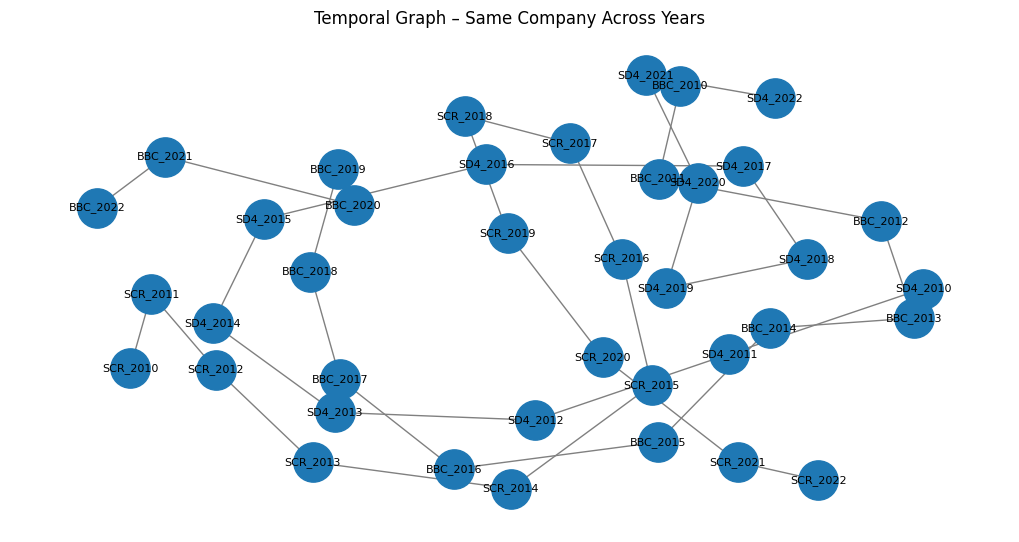

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# chọn vài công ty để minh họa
CODES = ["SD4", "SCR", "BBC"]
df_temp = df[df["Code"].isin(CODES)].copy()

G_temp = nx.Graph()

# add nodes
for _, r in df_temp.iterrows():
    node = f"{r.Code}_{r.Year}"
    G_temp.add_node(node, label=r.Code)

# add temporal edges
for code, g in df_temp.groupby("Code"):
    g = g.sort_values("Year")
    nodes = [f"{r.Code}_{r.Year}" for r in g.itertuples()]
    for i in range(len(nodes) - 1):
        G_temp.add_edge(nodes[i], nodes[i+1])

# layout
pos = nx.spring_layout(G_temp, seed=42, k=0.6)

plt.figure(figsize=(10,5))
nx.draw(
    G_temp, pos,
    with_labels=True,
    node_size=800,
    font_size=8,
    edge_color="gray"
)
plt.title("Temporal Graph – Same Company Across Years")
plt.axis("off")
plt.show()

In [ ]:
print(df.columns.tolist())

['Code', 'Year', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'SEN', 'Next_year_binary_distress_label', 'Code_clean', 'Sector', 'node_id']


['Xây dựng', 'Vật liệu xây dựng & Nội thất', 'Bất động sản', 'Nuôi trồng nông & hải sản', 'Thực phẩm']


/tmp/ipython-input-1334140570.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


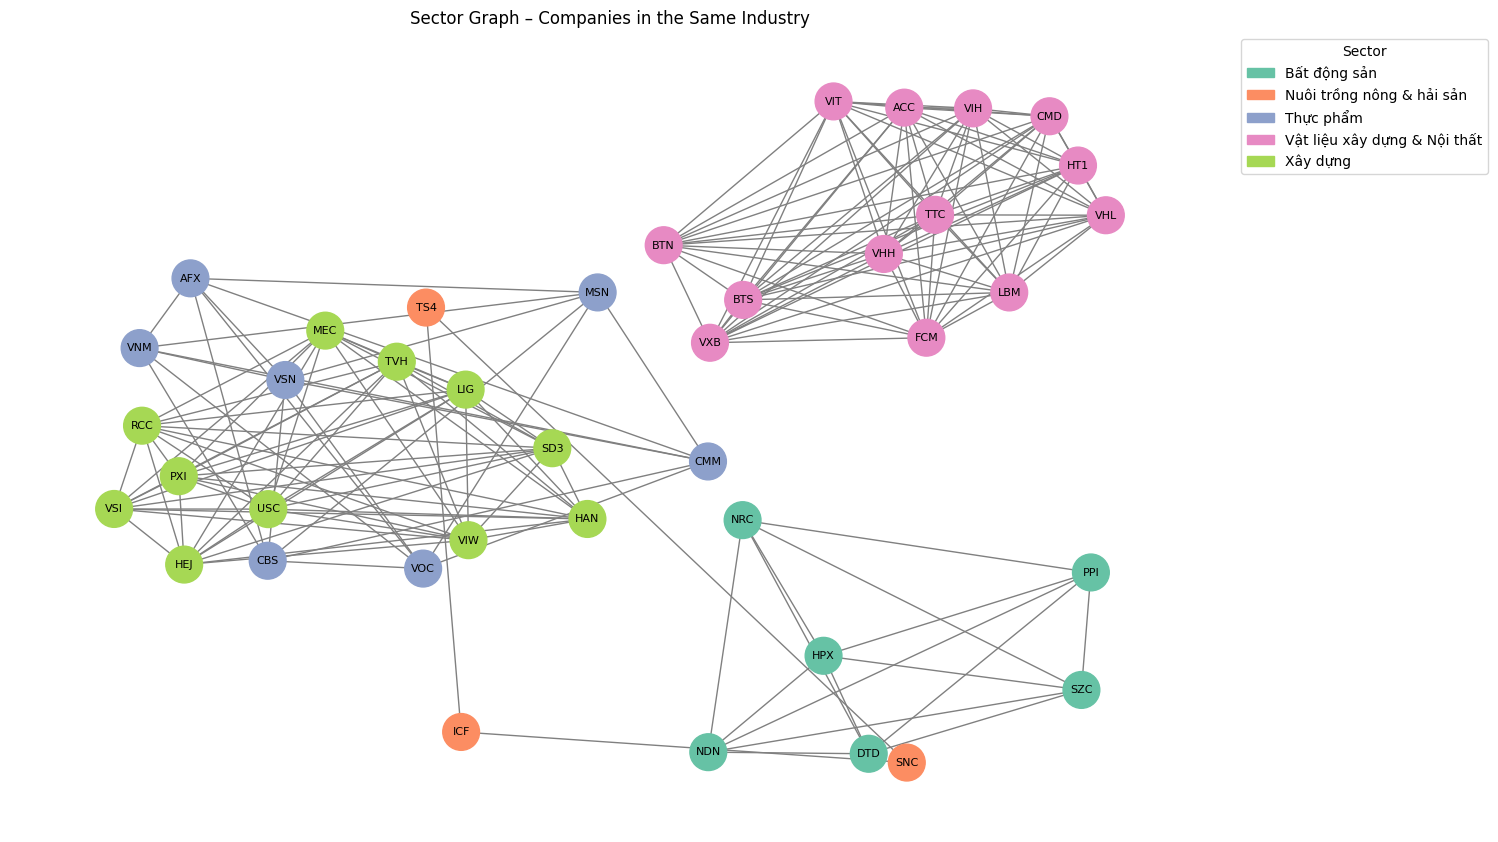

In [ ]:
TOP_K = 5

top_sectors = (
    df["Sector"]
    .value_counts()
    .head(TOP_K)
    .index
    .tolist()
)

print(top_sectors)

df_sector = (
    df[df["Sector"].isin(top_sectors)]
    .sample(40, random_state=1)
    .reset_index(drop=True)
)


G_sec = nx.Graph()

# add nodes
for i, r in df_sector.iterrows():
    G_sec.add_node(
        i,
        ticker=r["Code"],
        sector=r["Sector"]
    )

# add edges: companies in the same sector
for sector, g in df_sector.groupby("Sector"):
    nodes = g.index.tolist()
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            G_sec.add_edge(nodes[i], nodes[j])

# layout
pos = nx.spring_layout(G_sec, seed=42, k=1.2)

# labels
labels = {i: G_sec.nodes[i]["ticker"] for i in G_sec.nodes}

# colors by sector
sectors = [G_sec.nodes[i]["sector"] for i in G_sec.nodes]
sector_names = sorted(set(sectors))
sector_colors = {s: plt.cm.Set2(i) for i, s in enumerate(sector_names)}
node_colors = [sector_colors[G_sec.nodes[i]["sector"]] for i in G_sec.nodes]

plt.figure(figsize=(12,8))

nx.draw(
    G_sec, pos,
    labels=labels,
    node_color=node_colors,
    node_size=700,
    font_size=8,
    edge_color="gray"
)

# legend
handles = [
    mpatches.Patch(color=sector_colors[s], label=s)
    for s in sector_names
]

plt.legend(
    handles=handles,
    title="Sector",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)

plt.title("Sector Graph – Companies in the Same Industry")
plt.axis("off")
plt.tight_layout()
plt.show()

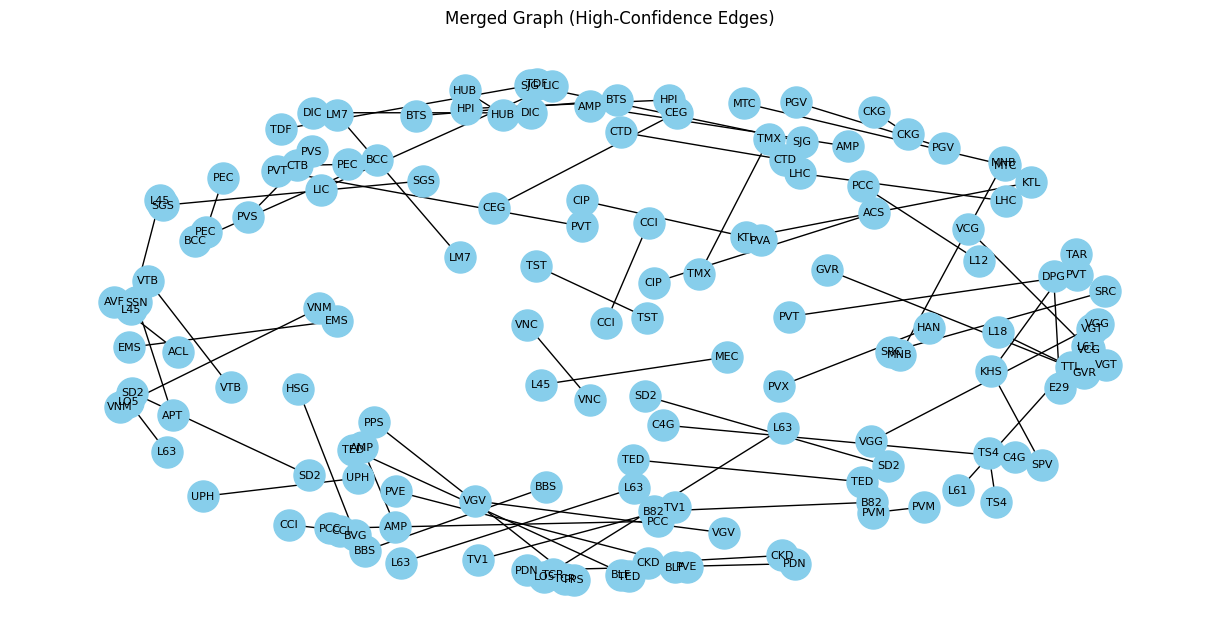

In [ ]:
np.random.seed(42)

TOP_K = 150   # tăng lên nếu muốn dày hơn

idx = torch.topk(edge_weight, TOP_K).indices
edges_draw = edge_index[:, idx].t().tolist()
weights_draw = edge_weight[idx].tolist()

G = nx.Graph()
for (i, j), w in zip(edges_draw, weights_draw):
    G.add_edge(i, j, weight=w)

pos = nx.spring_layout(G, seed=42, k=0.5)

plt.figure(figsize=(12,6))
nx.draw(
    G, pos,
    labels={i: df.loc[i,"Code"] for i in G.nodes},
    node_size=500,
    node_color="skyblue",
    font_size=8,
    edge_color="black"
)

plt.title("Merged Graph (High-Confidence Edges)")
plt.axis("off")
plt.show()

#### Simple Check

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

feature_cols = [c for c in df.columns if c.startswith("X")] + ["SEN"]

df[feature_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
X1,12678.0,1.972855,2.712076,0.005401,1.033484,1.315649,2.044612,113.000000
X2,12678.0,0.115670,1.054891,-80.562500,0.015687,0.133999,0.297854,0.965517
X3,12678.0,0.429046,7.545496,-112.785714,0.014659,0.134510,0.384130,440.333333
X4,12678.0,0.053756,0.134963,-5.437500,0.013001,0.045008,0.094449,1.558271
X5,12678.0,0.410049,1.965060,-34.375000,0.155574,0.314357,0.539646,203.000000
X6,12678.0,0.160238,0.141958,-0.731481,0.064103,0.125142,0.224926,2.036364
X7,12678.0,0.042804,1.205652,-68.937500,0.014599,0.048951,0.120253,44.400000
X8,12678.0,-0.023001,1.225176,-92.250000,0.010302,0.041534,0.091255,1.279608
X9,12678.0,1.125847,1.214232,-0.126422,0.409314,0.839765,1.431707,20.081967
X10,12678.0,0.453270,1.049868,0.004975,0.223857,0.398572,0.585992,81.000000


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

df_sub = df.sample(1500, random_state=42)

X = df_sub[feature_cols].values
X = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-8)

sim = cosine_similarity(X)

# chỉ lấy upper triangle (tránh self-similarity)
sims = sim[np.triu_indices_from(sim, k=1)]

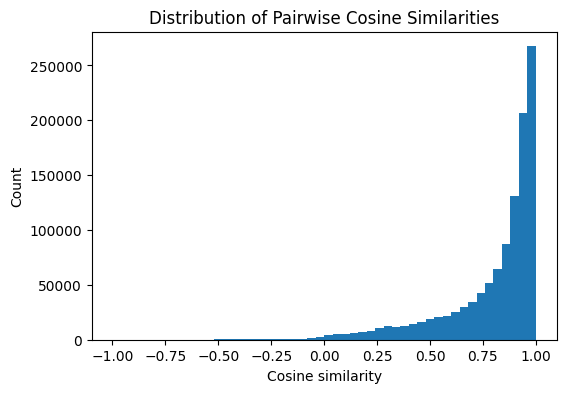

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(sims, bins=50)
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.title("Distribution of Pairwise Cosine Similarities")
plt.show()

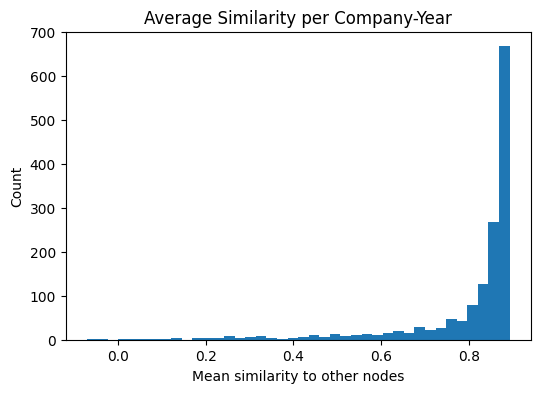

(np.float64(0.7993204809675466), np.float64(-0.07034930533312131))

In [ ]:
mean_sim_per_node = sim.mean(axis=1)

plt.figure(figsize=(6,4))
plt.hist(mean_sim_per_node, bins=40)
plt.xlabel("Mean similarity to other nodes")
plt.ylabel("Count")
plt.title("Average Similarity per Company-Year")
plt.show()

mean_sim_per_node.mean(), mean_sim_per_node.min()

In [ ]:
df_sub["idx"] = range(len(df_sub))

pairs = []
for i in range(len(df_sub)):
    for j in range(i+1, len(df_sub)):
        same_sector = df_sub.iloc[i]["Sector"] == df_sub.iloc[j]["Sector"]
        pairs.append((sim[i, j], same_sector))

pairs = pd.DataFrame(pairs, columns=["sim", "same_sector"])

pairs.groupby("same_sector")["sim"].mean()

,sim
same_sector,
False,0.799632
True,0.790502


Same-sector similarity ≈ different-sector similarity

Financial distress không phải hiện tượng “theo ngành” thuần túy
→ sector chỉ đóng vai trò phụ trợ

Although financial indicators appear highly similar across firms, distress is often driven by relative and contextual differences rather than absolute values. Graph Neural Networks enable the model to incorporate relational context, allowing subtle but meaningful deviations to propagate through the network, which enhances discriminative capability under highly homogeneous feature distributions.

# Multiple GNN Models Test - N

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected
import numpy as np
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Load data
df = pd.read_csv("/content/drive/MyDrive/KLTN/FDP_VN_1year_binary_FIN_WEIGHTED_SEN_2010_2023.csv")

feature_cols = [c for c in df.columns if c.startswith("X")] + ["SEN"]

X = torch.tensor(df[feature_cols].values, dtype=torch.float).to(device)
y = torch.tensor(df["Next_year_binary_distress_label"].values, dtype=torch.long).to(device)

# ===== TEMPORAL MASK =====
years = df["Year"].values

train_mask_global = torch.tensor(years <= 2021, dtype=torch.bool, device=device)
test_mask_global  = torch.tensor(years == 2022, dtype=torch.bool, device=device)

print("Train samples:", train_mask_global.sum().item())
print("Test samples :", test_mask_global.sum().item())

Train samples: 11634
Test samples : 1044


In [ ]:
data = Data(
    x=X,
    edge_index=edge_index.to(device),
    edge_weight=edge_weight.to(device),
    y=y
).to(device)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, f1_score

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0,1]),
    y=df["Next_year_binary_distress_label"].values
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

Class weights: tensor([0.6654, 2.0117], device='cuda:0')


In [ ]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim, add_self_loops=True)
        self.conv2 = GCNConv(hidden_dim, out_dim, add_self_loops=True)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, out_dim)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout, heads=4):
        super().__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_dim * heads, out_dim, heads=1, concat=False)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
def tune_model(model_class, model_name):
    # ===== CHỈ LẤY TRAIN DATA (2010–2021) =====
    train_indices = train_mask_global.nonzero(as_tuple=True)[0].cpu().numpy()
    y_train_all = y[train_mask_global].detach().cpu().numpy()

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    hidden_dims = [32, 64, 128]
    lrs = [5e-4, 1e-3, 3e-3]
    dropouts = [0.3, 0.5]
    weight_decays = [1e-4, 5e-4]
    use_weighted_loss = [False, True]

    best_macro_f1 = 0
    best_config = None

    for hd in hidden_dims:
        for lr in lrs:
            for dp in dropouts:
                for wd in weight_decays:
                    for weighted in use_weighted_loss:

                        fold_f1 = []

                        # ===== K-FOLD CHỈ TRÊN TRAIN (2010–2021) =====
                        for tr_idx, val_idx in skf.split(train_indices, y_train_all):

                            fold_train_mask = torch.zeros(len(y), dtype=torch.bool, device=device)
                            fold_val_mask   = torch.zeros(len(y), dtype=torch.bool, device=device)

                            fold_train_mask[train_indices[tr_idx]] = True
                            fold_val_mask[train_indices[val_idx]]  = True

                            model = model_class(
                                in_dim=X.shape[1],
                                hidden_dim=hd,
                                out_dim=2,
                                dropout=dp
                            ).to(device)

                            optimizer = torch.optim.Adam(
                                model.parameters(), lr=lr, weight_decay=wd
                            )

                            # ===== TRAIN =====
                            for epoch in range(1, 51):
                                model.train()
                                optimizer.zero_grad()
                                out = model(data)

                                if weighted:
                                    loss = F.cross_entropy(
                                        out[fold_train_mask],
                                        y[fold_train_mask],
                                        weight=class_weights
                                    )
                                else:
                                    loss = F.cross_entropy(
                                        out[fold_train_mask],
                                        y[fold_train_mask]
                                    )

                                loss.backward()
                                optimizer.step()

                            # ===== VALIDATION (KHÔNG PHẢI 2022) =====
                            model.eval()
                            with torch.no_grad():
                                logits = model(data)
                                preds = logits[fold_val_mask].argmax(dim=1)
                                f1 = f1_score(
                                    y[fold_val_mask].cpu(),
                                    preds.cpu(),
                                    average="macro"
                                )

                                fold_f1.append(f1)

                        mean_f1 = np.mean(fold_f1)

                        if mean_f1 > best_macro_f1:
                            best_macro_f1 = mean_f1
                            best_config = (hd, lr, dp, wd, weighted)

                        print(
                            f"{model_name} | hd={hd}, lr={lr}, dp={dp}, wd={wd}, weighted={weighted} → Macro-F1={mean_f1:.4f}"
                        )

    print("\n==============================")
    print(f"BEST {model_name}")
    print("Macro-F1:", best_macro_f1)
    print("Config:", best_config)
    print("==============================")

    return best_config

In [ ]:
def final_train_and_test(model_class, model_name, best_config):
    hd, lr, dp, wd, weighted = best_config

    model = model_class(
        in_dim=X.shape[1],
        hidden_dim=hd,
        out_dim=2,
        dropout=dp
    ).to(device)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=lr, weight_decay=wd
    )

    # ===== TRAIN TRÊN TOÀN BỘ 2010–2021 =====
    for epoch in range(1, 101):
        model.train()
        optimizer.zero_grad()
        out = model(data)

        if weighted:
            loss = F.cross_entropy(
                out[train_mask_global],
                y[train_mask_global],
                weight=class_weights
            )
        else:
            loss = F.cross_entropy(
                out[train_mask_global],
                y[train_mask_global]
            )

        loss.backward()
        optimizer.step()

    # ===== TEST DUY NHẤT TRÊN 2022 =====
    model.eval()
    with torch.no_grad():
        logits = model(data)
        preds = logits[test_mask_global].argmax(dim=1).cpu().numpy()
        labels = y[test_mask_global].cpu().numpy()

    print(f"\n===== FINAL TEST REPORT (2022): {model_name} =====")
    print(classification_report(labels, preds, digits=4))

In [ ]:
best_gcn = tune_model(GCN, "GCN")
final_train_and_test(GCN, "GCN", best_gcn)

GCN | hd=32, lr=0.0005, dp=0.3, wd=0.0001, weighted=False → Macro-F1=0.4612
GCN | hd=32, lr=0.0005, dp=0.3, wd=0.0001, weighted=True → Macro-F1=0.6121
GCN | hd=32, lr=0.0005, dp=0.3, wd=0.0005, weighted=False → Macro-F1=0.5193
GCN | hd=32, lr=0.0005, dp=0.3, wd=0.0005, weighted=True → Macro-F1=0.5471
GCN | hd=32, lr=0.0005, dp=0.5, wd=0.0001, weighted=False → Macro-F1=0.5091
GCN | hd=32, lr=0.0005, dp=0.5, wd=0.0001, weighted=True → Macro-F1=0.5626
GCN | hd=32, lr=0.0005, dp=0.5, wd=0.0005, weighted=False → Macro-F1=0.4926
GCN | hd=32, lr=0.0005, dp=0.5, wd=0.0005, weighted=True → Macro-F1=0.5436
GCN | hd=32, lr=0.001, dp=0.3, wd=0.0001, weighted=False → Macro-F1=0.5280
GCN | hd=32, lr=0.001, dp=0.3, wd=0.0001, weighted=True → Macro-F1=0.5963
GCN | hd=32, lr=0.001, dp=0.3, wd=0.0005, weighted=False → Macro-F1=0.5714
GCN | hd=32, lr=0.001, dp=0.3, wd=0.0005, weighted=True → Macro-F1=0.6206
GCN | hd=32, lr=0.001, dp=0.5, wd=0.0001, weighted=False → Macro-F1=0.5376
GCN | hd=32, lr=0.001, 

In [ ]:
best_sage = tune_model(GraphSAGE, "GraphSAGE")
final_train_and_test(GraphSAGE, "GraphSAGE", best_sage)

GraphSAGE | hd=32, lr=0.0005, dp=0.3, wd=0.0001, weighted=False → Macro-F1=0.5204
GraphSAGE | hd=32, lr=0.0005, dp=0.3, wd=0.0001, weighted=True → Macro-F1=0.6302
GraphSAGE | hd=32, lr=0.0005, dp=0.3, wd=0.0005, weighted=False → Macro-F1=0.5305
GraphSAGE | hd=32, lr=0.0005, dp=0.3, wd=0.0005, weighted=True → Macro-F1=0.6155
GraphSAGE | hd=32, lr=0.0005, dp=0.5, wd=0.0001, weighted=False → Macro-F1=0.5173
GraphSAGE | hd=32, lr=0.0005, dp=0.5, wd=0.0001, weighted=True → Macro-F1=0.6443
GraphSAGE | hd=32, lr=0.0005, dp=0.5, wd=0.0005, weighted=False → Macro-F1=0.5375
GraphSAGE | hd=32, lr=0.0005, dp=0.5, wd=0.0005, weighted=True → Macro-F1=0.6496
GraphSAGE | hd=32, lr=0.001, dp=0.3, wd=0.0001, weighted=False → Macro-F1=0.5681
GraphSAGE | hd=32, lr=0.001, dp=0.3, wd=0.0001, weighted=True → Macro-F1=0.6650
GraphSAGE | hd=32, lr=0.001, dp=0.3, wd=0.0005, weighted=False → Macro-F1=0.5776
GraphSAGE | hd=32, lr=0.001, dp=0.3, wd=0.0005, weighted=True → Macro-F1=0.6540
GraphSAGE | hd=32, lr=0.00

In [ ]:
best_gat = tune_model(GAT, "GAT")
final_train_and_test(GAT, "GAT", best_gat)

GAT | hd=32, lr=0.0005, dp=0.3, wd=0.0001, weighted=False → Macro-F1=0.5718
GAT | hd=32, lr=0.0005, dp=0.3, wd=0.0001, weighted=True → Macro-F1=0.4344
GAT | hd=32, lr=0.0005, dp=0.3, wd=0.0005, weighted=False → Macro-F1=0.5550
GAT | hd=32, lr=0.0005, dp=0.3, wd=0.0005, weighted=True → Macro-F1=0.6334
GAT | hd=32, lr=0.0005, dp=0.5, wd=0.0001, weighted=False → Macro-F1=0.5463
GAT | hd=32, lr=0.0005, dp=0.5, wd=0.0001, weighted=True → Macro-F1=0.3421
GAT | hd=32, lr=0.0005, dp=0.5, wd=0.0005, weighted=False → Macro-F1=0.5548
GAT | hd=32, lr=0.0005, dp=0.5, wd=0.0005, weighted=True → Macro-F1=0.4524
GAT | hd=32, lr=0.001, dp=0.3, wd=0.0001, weighted=False → Macro-F1=0.5923
GAT | hd=32, lr=0.001, dp=0.3, wd=0.0001, weighted=True → Macro-F1=0.5788
GAT | hd=32, lr=0.001, dp=0.3, wd=0.0005, weighted=False → Macro-F1=0.5891
GAT | hd=32, lr=0.001, dp=0.3, wd=0.0005, weighted=True → Macro-F1=0.6078
GAT | hd=32, lr=0.001, dp=0.5, wd=0.0001, weighted=False → Macro-F1=0.5554
GAT | hd=32, lr=0.001, 

In [ ]:
import torch
import numpy as np
import pandas as pd

def compute_homophily(edge_index, y):
    """
    edge_index: [2, E] (torch tensor)
    y: [N] labels (0/1)
    """
    src = edge_index[0].cpu().numpy()
    dst = edge_index[1].cpu().numpy()
    y_np = y.cpu().numpy()

    same_label = 0
    diff_label = 0
    dd = 0  # distress-distress
    nn = 0  # non-distress
    dn = 0  # cross

    for u, v in zip(src, dst):
        if y_np[u] == y_np[v]:
            same_label += 1
            if y_np[u] == 1:
                dd += 1
            else:
                nn += 1
        else:
            diff_label += 1
            dn += 1

    total = same_label + diff_label

    results = {
        "homophily_ratio": same_label / total,
        "distress-distress_ratio": dd / total,
        "non-non_ratio": nn / total,
        "cross_ratio": dn / total,
        "num_edges": total
    }

    return results


# ===== RUN =====
homo_stats = compute_homophily(edge_index, data.y)

for k, v in homo_stats.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

homophily_ratio: 0.7652
distress-distress_ratio: 0.1223
non-non_ratio: 0.6429
cross_ratio: 0.2348
num_edges: 105232
